In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud,STOPWORDS

# <span style="color: maroon"> Loading, Cleaning, Transforming  Data 
### 1.) Product Data : _We drop irrelavant columns and use product name column to extract brand name and number of masks(as few product_ids has pack of masks), it is then used to calculate the price per mask._
### 2.) Review Data: _We drop duplicated rows and irrelavant Columns and get "Average Rating value" and "Number of Reviews" for each product._

In [2]:
                       ##############  PRODUCT DATA  #################

product_data=pd.read_excel(r'C:\Users\himan\Desktop\Data Visualization\Assignment 3\products (1).xls')

## Dropping irrelavant columns

product_data.drop(['product_availability', 'product_url', 'source_url'],axis=1,inplace=True)

## extracting brand name in a new column
product_data['brand_name']=product_data['product_name'].str.split(",").str[0]


## Getting number of masks in a new column

product_data['number_of_masks']=product_data['product_name'].apply(lambda x : int(re.findall('\s\d+\s',x)[-1]))
product_data['number_of_masks']=product_data['number_of_masks'].replace(24,1)


##Adding a new column having price per mask 
product_data['price_per_mask']=product_data['product_price']/product_data['number_of_masks']


## Categorising the mask based on keywords present in product_name
keywords = ["Disposable", "Reusable","Reuseable","Copper Mask"]

def ty(a):
    for word in keywords:
        if word in a:
            if word in ("Reusable","Reuseable"):
                return "Reusable"
            else:
                return word
    return "others"
product_data["mask_type"] = product_data.product_name.apply(lambda x: ty(x))
product_data.head()
    

,product_id,product_name,product_price,price_currency,brand_name,number_of_masks,price_per_mask,mask_type
0,103205,"Hwipure, Disposable KF94 ( N95 / KN95/ FFP2 ) ...",2.95,AUD,Hwipure,1,2.950,Disposable
1,101774,"HIGUARD, Disposable KF94 ( N95 / KN95/ FFP2 ) ...",2.95,AUD,HIGUARD,1,2.950,Disposable
2,101955,"SunJoy, KN95, Professional Protective Disposab...",8.86,AUD,SunJoy,10,0.886,Disposable
3,103838,"Lozperi, Copper Mask, Adult, Black, 1 Mask",6.85,AUD,Lozperi,1,6.850,Copper Mask
4,102734,"Zidian, Disposable Protective Mask, 50 Pack",15.35,AUD,Zidian,50,0.307,Disposable


In [3]:
                        ################# REVIEW DATA #########################

## load review data
review_data=pd.read_excel(r'C:\Users\himan\Desktop\Data Visualization\Assignment 3\reviews_modified.xlsx')

original_len=len(review_data)

## Dropping duplicated rows

review_data.drop_duplicates(inplace=True)
new_len=len(review_data)

print(f'Number of dulpcates in review data :', original_len-new_len)

## Renaming column to match with Product Data
review_data.rename(columns={'productId':'product_id'},inplace=True)


## Getting review text in one column by merging english reviews and translated reviews
review_data['review_text']=review_data.apply(lambda x: x['reviewText'] if str(x['translation.reviewText'])=='nan' else x['translation.reviewText'], axis=1)
review_data.drop(['reviewText','translation.reviewText'],axis=1,inplace=True)

 ################    AGGREGATING DATA #########
    
## Extracting useful information 
rating_data=review_data.groupby('product_id').agg(Average_Rating = ('ratingValue', 'mean'), Ratings_Count=('product_id','count')).sort_values(by=['Ratings_Count'],ascending=False)

## Merging Rating data(Avergae_Rating, Ratings_Count) with product data and sorting by number of ratings/reviews in descending order
modified_data=product_data.merge(rating_data,on='product_id',how='left').sort_values('Ratings_Count',ascending=False)
modified_data.reset_index(drop=True,inplace=True)

modified_data.head()

Number of dulpcates in review data : 84


,product_id,product_name,product_price,price_currency,brand_name,number_of_masks,price_per_mask,mask_type,Average_Rating,Ratings_Count
0,101955,"SunJoy, KN95, Professional Protective Disposab...",8.86,AUD,SunJoy,10,0.886000,Disposable,44.285714,658
1,100237,"Kitsch, 100% Cotton Reuseable Face Masks, Leop...",17.72,AUD,Kitsch,3,5.906667,Reusable,42.283019,530
2,99830,"Kosette, Nano Reusable Face Protection Mask, M...",22.44,AUD,Kosette,1,22.440000,Reusable,45.326316,475
3,102734,"Zidian, Disposable Protective Mask, 50 Pack",15.35,AUD,Zidian,50,0.307000,Disposable,46.498516,337
4,99829,"Kosette, Nano Reusable Face Protection Mask, L...",22.44,AUD,Kosette,1,22.440000,Reusable,45.361842,304


# <span style="color: maroon"> EDA

## <span style="color: maroon"> 1.) Preliminary EDA: Relationship between price and rating

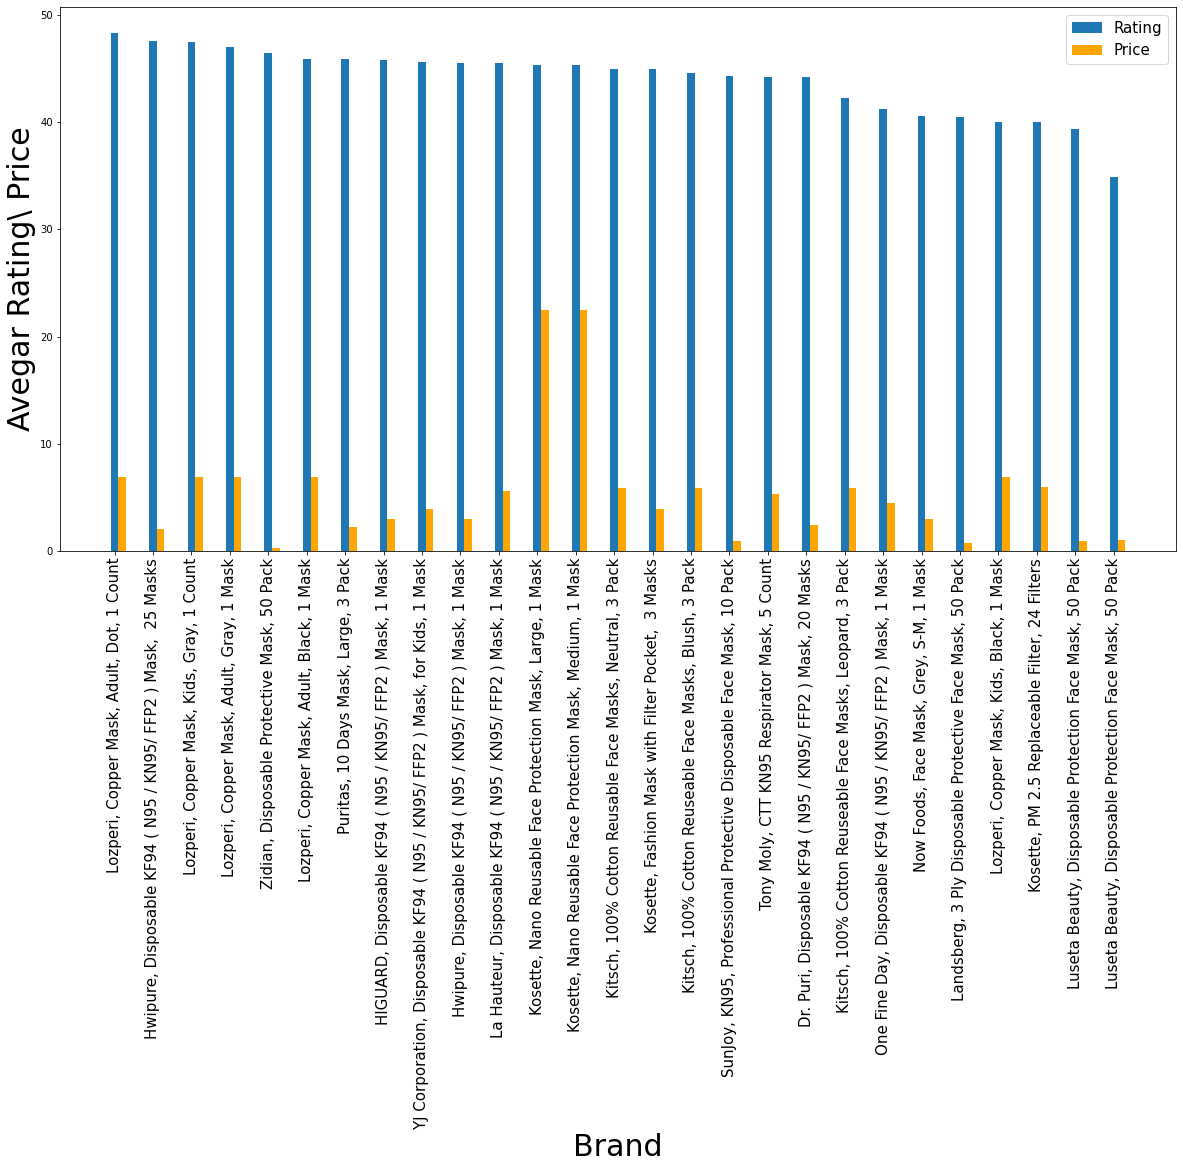

In [4]:
## Sorting data on rating

modified_data_1=modified_data.sort_values('Average_Rating',ascending=False)


## Plotting rating and price values for every brand 
w=0.8
fig=plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
pos=np.arange(1,4*len(modified_data),4)
plt.bar(pos,modified_data_1['Average_Rating'],width=w)
plt.ylabel('Product Rating',fontsize=30)
plt.xticks(pos, modified_data_1['brand_name'], rotation =45,fontsize=15)
#fig=plt.figure()
#fig.set_figheight(10)
#fig.set_figwidth(20)
plt.bar(pos+w,modified_data_1['price_per_mask'],width=w,color='orange')
plt.ylabel('Avegar Rating\ Price',fontsize=30)
plt.xlabel('Brand',fontsize=30)
plt.xticks(pos, modified_data_1['product_name'], rotation =90,fontsize=15)
plt.legend(['Rating','Price'],fontsize=15)
plt.show()


### _We can not observe any direct correlation between Rating and Price. Some brands have high rating while their price per mask is very low; on the other hand, some brands have high price but their ratings are not great._

##  <span style="color:maroon">2.) Analysing different mask categories

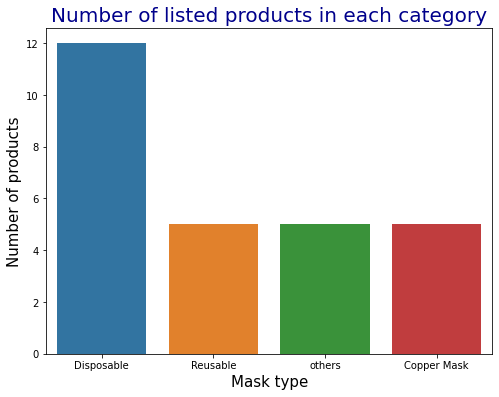

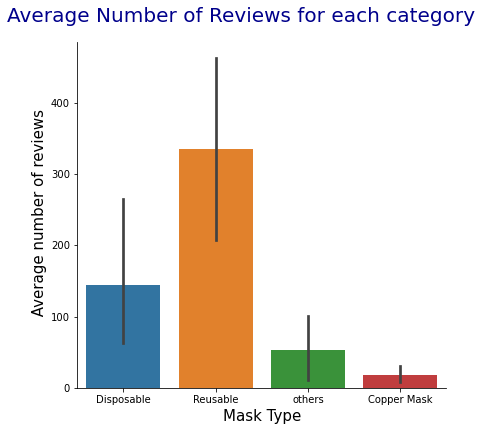

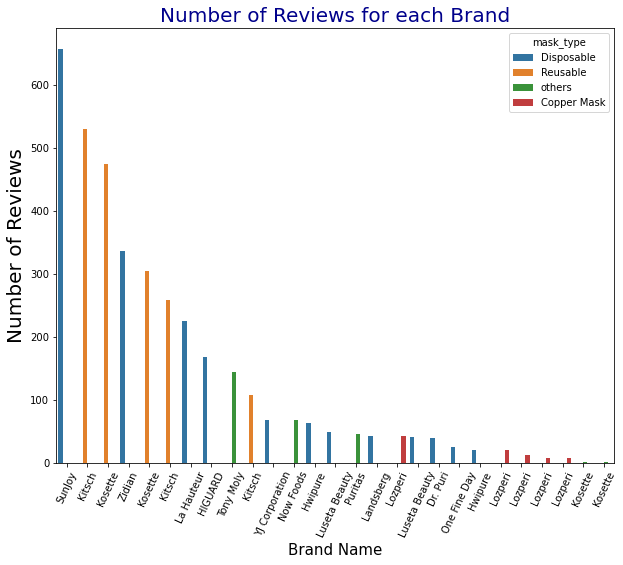

In [5]:

## Plotting count of listingss within each mask category

fig=plt.figure()
fig.set_figwidth(8)
fig.set_figheight(6)
plot1=sns.countplot(x=modified_data['mask_type'])
plot1.set_title(("Number of listed products in each category"),size=20,color='Darkblue')
plot1.set_xlabel('Mask type',size=15)
plot1.set_ylabel('Number of products',size=15)


## Plotting average number of reviews for each mask in each category(to know the popularity)
plot2=sns.catplot(data=modified_data,x='mask_type',y='Ratings_Count',kind='bar',height=6)
plot2.figure.subplots_adjust(top=0.9);
plot2.fig.suptitle(("Average Number of Reviews for each category"),size=20,color='Darkblue')
plot2.set_axis_labels("Mask Type", " Average number of reviews",size=15)




## Plotting Number of reviews for each product
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(10)
pos=modified_data.index+1
plot3=sns.barplot(data=modified_data,x=pos,y='Ratings_Count',hue='mask_type')
plot3.set_xticklabels(modified_data['brand_name'],rotation=65,size=10)
plot3.set_ylabel("Number of Reviews",size=20)
plot3.set_xlabel('Brand Name',size=15)
plot3.set_title(("Number of Reviews for each Brand"),size=20,color='Darkblue')
plt.show()

### From the plots above, we can see that most number of listed products are from "Disposable" category. However, average number of user reviews are maximum for reusable masks making them most talked about/ popular mask type. Also, the top 3 popular brands are:Sunjoy, Kitsch and Kosette. 
### <span style="color:purple"> _We observe : competition is more in "Disposable" masks due to presence of multiple brands in that segment and reusable masks appear to be more in demand. So, we can advice our client to target the "Reusable" masks segment_

## <span style="color:maroon"> 3.) Analysing Good and Bad Reviews for Reusable Masks :


### We take all the good reviews(Ratings>30), bad reviews(Ratings<=20) and look at the commonly used words, it will help us to know what do consumers like about the masks

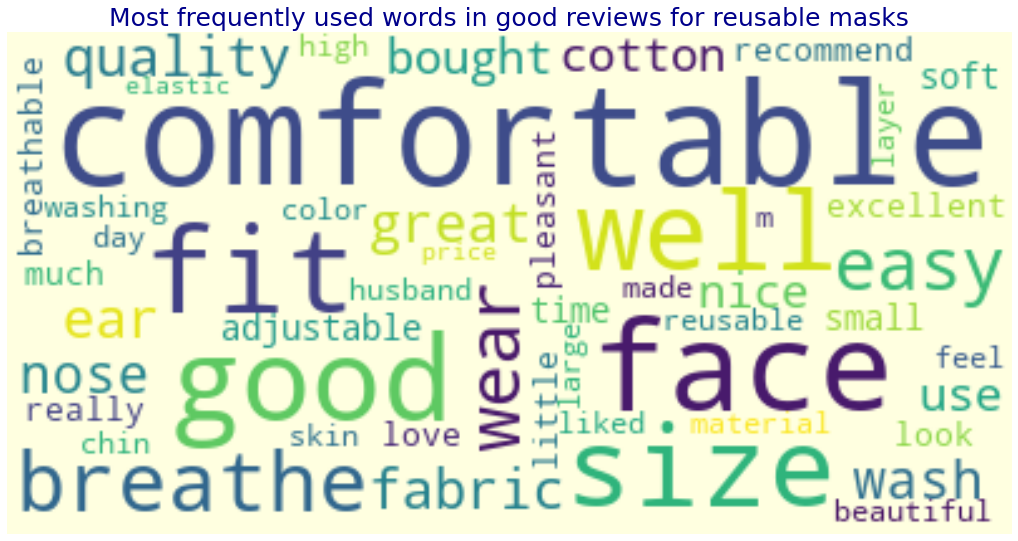

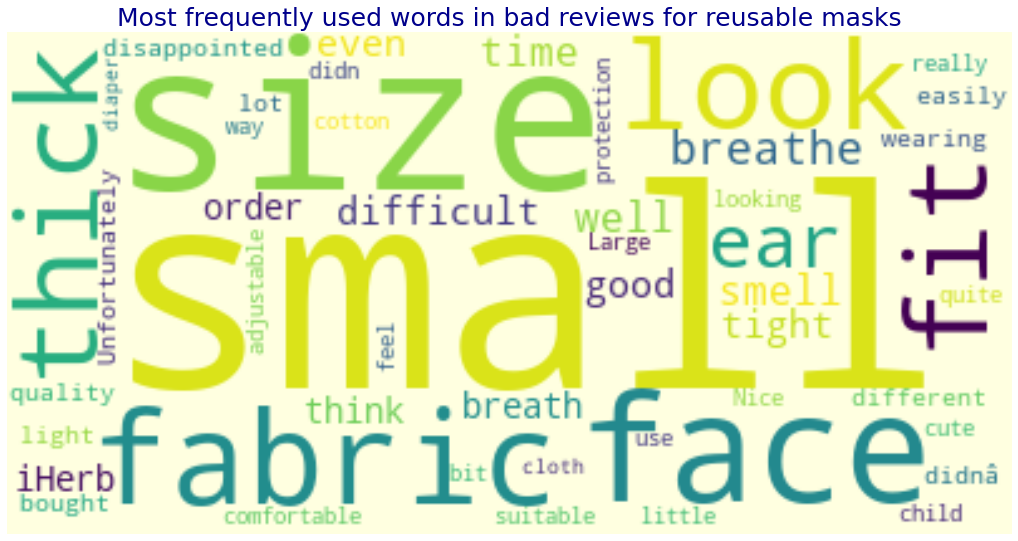

In [6]:
                        ######## GOOD REVIEWS ########
import wordcloud
from wordcloud import STOPWORDS
## Creating a new data frame "review_data_2" after merging product level details in  review column 
review_data_2=review_data.merge(modified_data,on='product_id',how='left')

## Creating a filter to het data for reusable masks with rating>30,
## filtering out irrelevant reviews by only taking entries with more helpful reviews

mask=review_data_2.apply(lambda x : isinstance(x['review_text'],str) and x['mask_type']=='Reusable' and x['helpfulYes']>=x['helpfulNo'] and x['ratingValue']>30 ,axis=1)

## Creating a figure and displaying the cloud of most used words in the filtered data
fig=plt.figure()
fig.set_figwidth(18)
fig.set_figheight(15)

## creating a string containing all reviews
text1="".join(review_data_2[mask]['review_text'])

## Creating  and visualizing a wordcloud of 20 most frequently used words in filtered reviews 

stop_words=STOPWORDS.update(['mask','one','s','masks','will','t'])
wordcloud=WordCloud(stopwords=stop_words,max_words=50,collocations=False,background_color='lightyellow').generate(text1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequently used words in good reviews for reusable masks',fontsize='25',color='darkblue')
#plt.set_edgecolor('black')
plt.show()

                     ########   BAD REVIEWS    ##########

## Performing similar steps as used for analysing good reviews

review_data_2=review_data.merge(modified_data,on='product_id',how='left')
mask_2=review_data_2.apply(lambda x : isinstance(x['review_text'],str) and x['mask_type']=='Reusable' and x['helpfulYes']>=x['helpfulNo'] and x['ratingValue']<=20 ,axis=1)

## Creating a figure and displaying the cloud of most used words in the filtered data
fig=plt.figure()
fig.set_figwidth(18)
fig.set_figheight(15)

## creating a string containing all reviews
text2="".join(review_data_2[mask_2]['review_text'])

## Creating  and visualizing a wordcloud of 20 most frequently used words in filtered reviews 
wordcloud=WordCloud(stopwords=stop_words,max_words=50,collocations=False,background_color='lightyellow').generate(text2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequently used words in bad reviews for reusable masks',fontsize='25',color='darkblue')
#plt.set_edgecolor('black')
plt.show()


   ### Following codeblock can be uncommented to see the exact frequency of common words

# create a dictionary of word frequencies
# text_dictionary = wordcloud.process_text(text1)
# # sort the dictionary
# word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

# #use words_ to print relative word frequencies
# rel_freq=wordcloud.words_

# #print results
# print(list(word_freq.items())[:20])
# print(list(rel_freq.items())[:5])

# text_dictionary_2 = wordcloud.process_text(text2)
# # sort the dictionary
# word_freq_2={k: v for k, v in sorted(text_dictionary_2.items(),reverse=True, key=lambda item: item[1])}

# #use words_ to print relative word frequencies
# rel_freq_2=wordcloud.words_

# #print results
# print(list(word_freq_2.items())[:20])
# print(list(rel_freq_2.items())[:5])
# review_data_2[mask_2].shape

### We can see the most <span style="color:purple"> good reviews <span style="color:black">are related to <span style="color:purple">Comfort, Fit, Size, Breathability  and Fabric Quality. <span style="color:black"> Additionally, most <span style="color:purple"> bad reviews <span style="color:black"> also complain about: <span style="color:purple"> the size, thickness, breathability and fabric.<span style="color:black"> So, based on the reviews, most important factors are Comfort and Breathability which require choosing good fabric and designing sizes for proper fit and breathability

## <span style="color:maroon"> 4.) Analysing User/Buyer Profiles
### We look for words indicating common relations in the reviews, it can help us to devise a targeted marketing strategy for our product

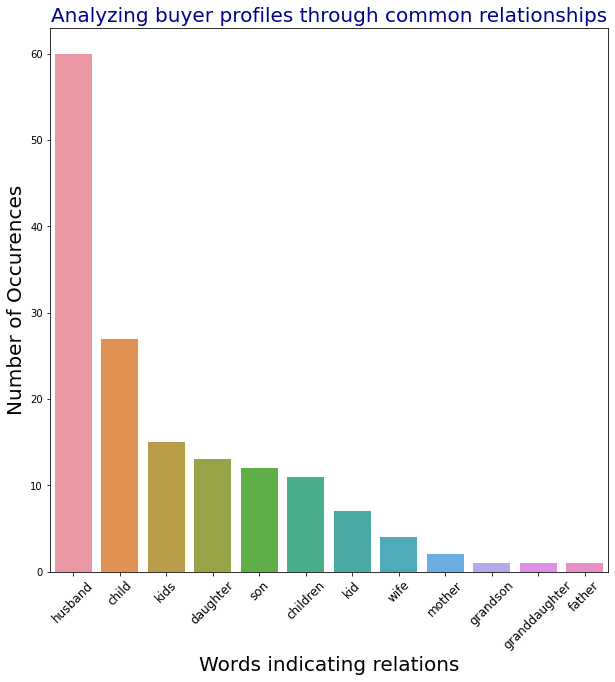

In [7]:
## Creating a mask to segregate only useful reviews

mask=review_data_2.apply(lambda x : isinstance(x['review_text'],str) and x['helpfulYes']>=x['helpfulNo'],axis=1)

## creating a string containing all reviews
text3=" ".join(review_data_2[mask]['review_text'])


## Creating a list of common relationships
words=['son','daughter','child','children','kid','kids','grandson','granddaughter','husband','wife','father','mother']

## Count dictionary will store the count for each keyword
count_dict={}
## Initializing count value for each keyword with zero  
for w in words:
    count_dict[w]=0
    

## Iterating over each word of the string having all reviews 
for s in text3.split():
    #print(s,w)
    for w in words:
        if s==w:
            count_dict[w]+=1
            

## sorting dictionary in desending order 
sorted_count_dict=dict(sorted(count_dict.items(), key=lambda item: item[1],reverse=True))

fig=plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
x=list(sorted_count_dict.keys())
y=list(sorted_count_dict.values())
plot=sns.barplot(x=x,y=y)
plot.set_xticklabels(x,rotation=45,size=12)
plot.set_ylabel("Number of Occurences",size=20)
plot.set_xlabel('Words indicating relations',size=20)
plot.set_title(("Analyzing buyer profiles through common relationships"),size=20,color='Darkblue')
plt.show()


### Plot aims to pick common relations(through associated words in reviews) which may provides us valuable insights about the profile of buyers and who they are buying masks for. 
### <span style="color:purple"> _We can observe that most frequent relationships are husband and children(son/daughter/child etc). This insight can help our client to focus on relevant segement of population with respect to product design and marketing._

***
# <span style="color:maroon">Conclusion :

### Based on the analysis of the provided product and mask data, we can present the following insights to our client:

### <span style="color:purple"> _a.) Looking at the market competition and popularity of various segments, we should look to enter the segment of reusable masks._
### <span style="color:purple">_b.) Consumers mostly focus on comfort(including size and fit of mask) and breathability. Hence, R & D should be focused on coming up with relevant design and use fabric, promoting the same._
### <span style="color:purple">_c.) Also, market strategy should focus more on gaining popularity amongst the wives and parents, buying masks for their husbands and children respectively._ 
***